In [1]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset

#dataset: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/data

class CityscapesDataset(Dataset):
    def __init__(self, image_dir, cut_half = True, transform = None):
        self.image_dir = image_dir
        self.imgs = os.listdir(image_dir)

        self.cut_half = cut_half
        self.transforms = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_mask = Image.open(os.path.join(self.image_dir, self.imgs[idx]))
        if self.cut_half:
            x_width, y_height = img_mask.size
            split = x_width / 2

            img = img_mask.crop((0, 0, split, y_height))

            mask = img_mask.crop((split, 0, split + split, y_height))

            if self.transforms:
                img = self.transforms(img)
                mask = self.transforms(mask)

            return img, mask

        return img_mask


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
transform_init = transform.Compose([
    transform.ToTensor()
])

dataset = CityscapesDataset(image_dir='/content/drive/MyDrive/5/train', cut_half=True, transform=transform_init)
val_dataset = CityscapesDataset(image_dir='/content/drive/MyDrive/5/val', cut_half=True, transform=transform_init)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset)
print(len(dataset), len(dataloader), len(valloader))



2975 93 500


torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


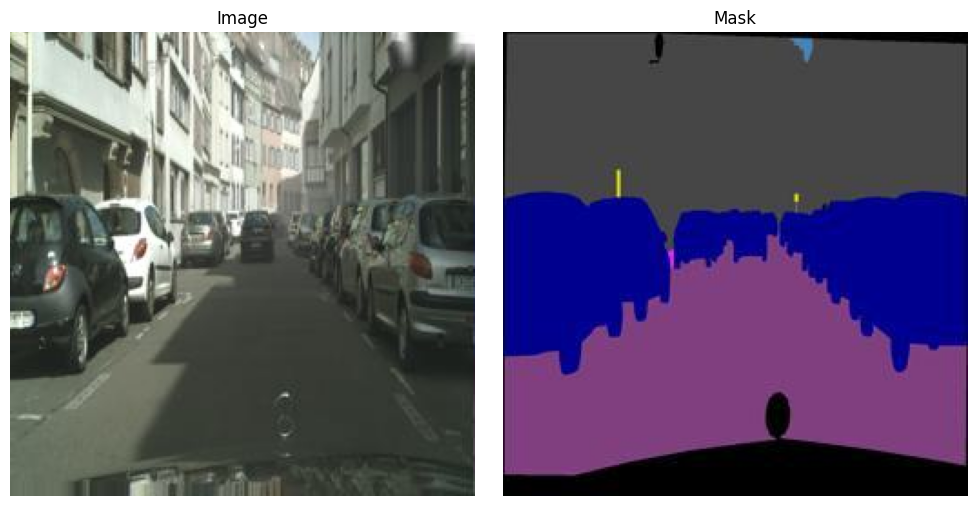

In [4]:
#Claude Opus 3 prompt: how would I view the images from a Dataset class in Pytorch?

img, mask = dataset[0]  # Change the index to view different images
print(img.shape, mask.shape)
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#own edits for correct data structure
img = torchvision.transforms.ToPILImage()(img)
mask = torchvision.transforms.ToPILImage()(mask)

# Display the image in the first subplot
ax1.imshow(img)
ax1.set_title('Image')
ax1.axis('off')

# Display the mask in the second subplot
ax2.imshow(mask)
ax2.set_title('Mask')
ax2.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

In [6]:
#https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/#residual-block

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.deconv1 = nn.ConvTranspose2d(512,256, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.deconv2 = nn.ConvTranspose2d(256,128, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.deconv3 = nn.ConvTranspose2d(128,64, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.deconv4 = nn.ConvTranspose2d(64,32, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.deconv5 = nn.ConvTranspose2d(32,3, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(3)
        self.relu = nn.ReLU()


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.conv1(x)

        x = self.maxpool(x)

        x = self.layer0(x)

        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)
        #print(np.shape(x))
        # From here we want reverses
        x = self.deconv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.deconv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.deconv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.deconv4(x)
        x = self.relu(x)
        x = self.bn4(x)
        x = self.deconv5(x)
        x = self.relu(x)
        x = self.bn5(x)

        #print(np.shape(x))

        #So now after having converted. We have

        return x





In [8]:

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)


from torchsummary import summary
summary(model, (3,224,224))

epochs = 20

loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_acc = []
val_acc = []
train_loss = []
val_loss = []


defogger_model = torch.load("/content/drive/MyDrive/18786 Project/model_r_defogger.pth")

summary(defogger_model, (3,224,224))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
    ResidualBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

100%|██████████| 93/93 [01:53<00:00,  1.22s/it]


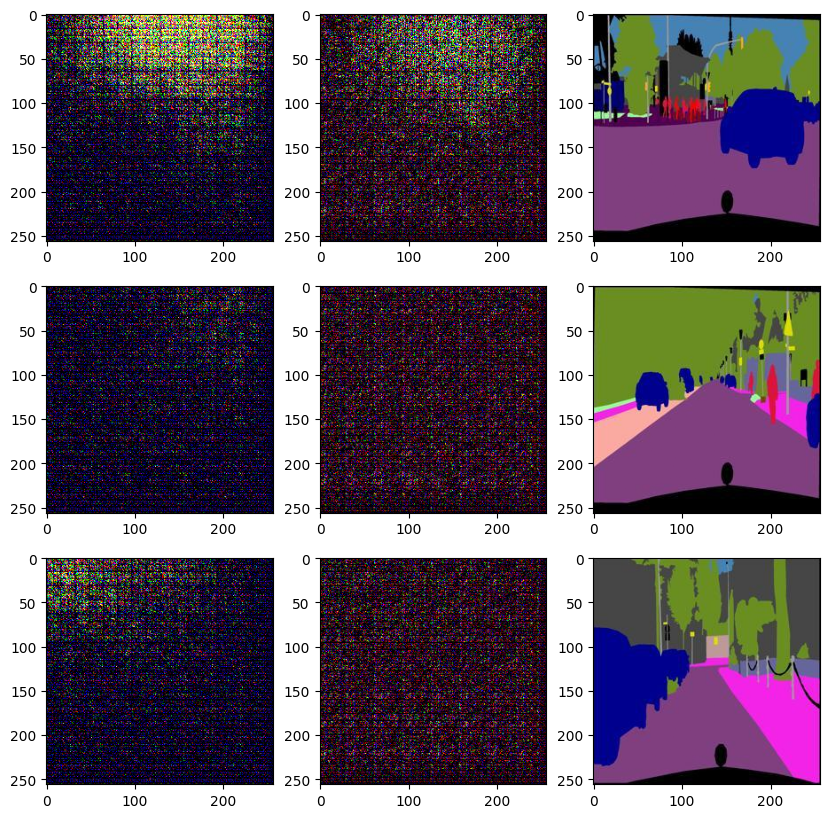

100%|██████████| 500/500 [03:13<00:00,  2.58it/s]


epoch : 2 ,train loss : 0.689104611514717 ,valid loss : 0.3622020891308784 


100%|██████████| 500/500 [00:14<00:00, 35.28it/s]


epoch : 1 ,train loss : 0.2297009748797263 ,valid loss : 0.13439401143789292 


100%|██████████| 500/500 [00:14<00:00, 35.58it/s]


epoch : 2 ,train loss : 0.09797239487850538 ,valid loss : 0.06956210596859455 


100%|██████████| 500/500 [00:14<00:00, 35.06it/s]


epoch : 3 ,train loss : 0.06028961538467356 ,valid loss : 0.05122433089464903 


100%|██████████| 500/500 [00:13<00:00, 36.68it/s]


epoch : 4 ,train loss : 0.04948760220600713 ,valid loss : 0.046092236157506704 


100%|██████████| 500/500 [00:13<00:00, 36.15it/s]


epoch : 5 ,train loss : 0.04640307830226037 ,valid loss : 0.044687603272497656 


100%|██████████| 500/500 [00:13<00:00, 36.42it/s]


epoch : 6 ,train loss : 0.045518693183698965 ,valid loss : 0.04431701397523284 


100%|██████████| 500/500 [00:15<00:00, 31.64it/s]


epoch : 7 ,train loss : 0.04526253521282186 ,valid loss : 0.04422949323803187 


100%|██████████| 500/500 [00:16<00:00, 30.78it/s]


epoch : 8 ,train loss : 0.04518926151657617 ,valid loss : 0.04421379789337516 


100%|██████████| 500/500 [00:15<00:00, 31.82it/s]


epoch : 9 ,train loss : 0.04517218061993199 ,valid loss : 0.04421331239119172 


100%|██████████| 93/93 [01:01<00:00,  1.50it/s]


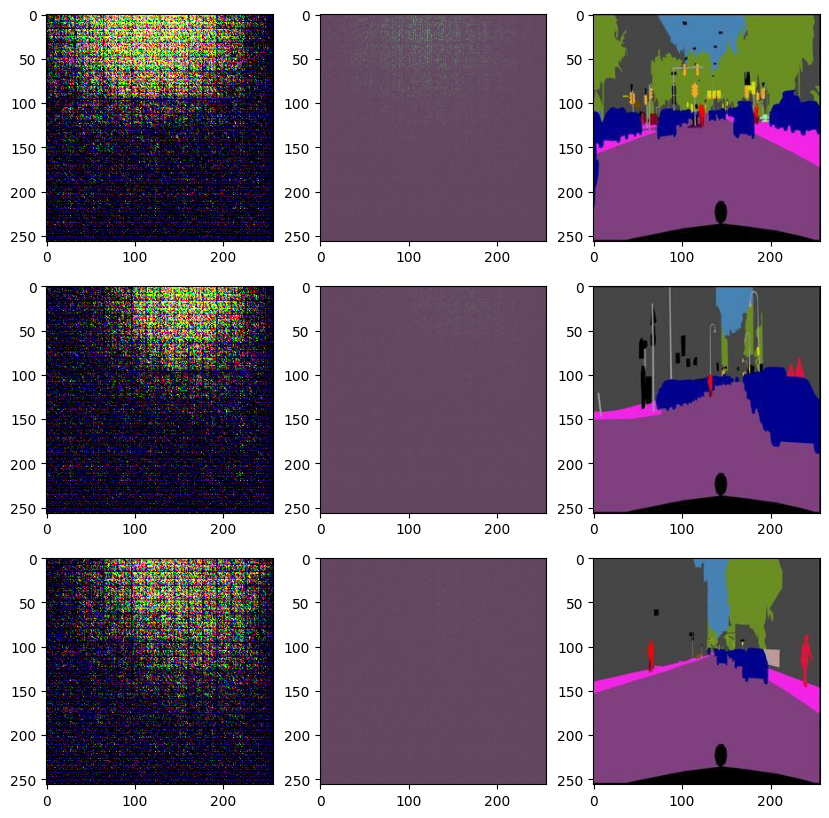

100%|██████████| 500/500 [00:16<00:00, 29.65it/s]


epoch : 2 ,train loss : 0.04516243934631348 ,valid loss : 0.04421392633020878 


100%|██████████| 500/500 [00:16<00:00, 30.58it/s]


epoch : 11 ,train loss : 0.04515957175403513 ,valid loss : 0.04421596108004451 


100%|██████████| 500/500 [00:15<00:00, 32.21it/s]


epoch : 12 ,train loss : 0.04515738745209991 ,valid loss : 0.044215641252696516 


100%|██████████| 500/500 [00:14<00:00, 34.18it/s]


epoch : 13 ,train loss : 0.04515841787540784 ,valid loss : 0.04421469130367041 


100%|██████████| 500/500 [00:16<00:00, 31.16it/s]


epoch : 14 ,train loss : 0.045158174930400745 ,valid loss : 0.044214695677161214 


100%|██████████| 500/500 [00:17<00:00, 29.32it/s]


epoch : 15 ,train loss : 0.045155146349501865 ,valid loss : 0.044213256660848854 


100%|██████████| 500/500 [00:16<00:00, 30.70it/s]


epoch : 16 ,train loss : 0.045156493021916315 ,valid loss : 0.04421197132766247 


100%|██████████| 500/500 [00:16<00:00, 29.82it/s]


epoch : 17 ,train loss : 0.04515263850810707 ,valid loss : 0.0442100625038147 


100%|██████████| 500/500 [00:15<00:00, 31.93it/s]


epoch : 18 ,train loss : 0.04515532284013687 ,valid loss : 0.04421039533242583 


100%|██████████| 500/500 [00:16<00:00, 31.23it/s]

epoch : 19 ,train loss : 0.045153080736116694 ,valid loss : 0.04420832687988877 


In [9]:
for i in range(epochs):

    trainloss = 0
    valloss = 0

    for img,label in tqdm(dataloader):
        #print("new image")
        optimizer.zero_grad()
        img = img.to(device)
        img = defogger_model(img)
        label = label.to(device)
        output = model(img)
        loss = loss_func(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()

    if(i%10==0):
      #visualizing the output every 2 epochs
      img_cpu,output_cpu,label_cpu = img.cpu(),output.cpu(),label.cpu()
      fig,ax = plt.subplots(3,3,figsize=(10,10))

      for i in range(3):
        int_img,int_output,int_label = img_cpu[i],output_cpu[i],label_cpu[i]
        int_img,int_output,int_label = int_img.detach(),int_output.detach().permute(1,2,0).numpy(),int_label
        ax[i][0].imshow(int_img.permute(1,2,0))
        ax[i][1].imshow(int_output)
        ax[i][2].imshow(int_label.permute(1,2,0))
      plt.show()

    train_loss.append(trainloss/len(dataloader))

    for img,label in tqdm(valloader):
        img = img.to(device)
        img = defogger_model(img)
        label = label.to(device)
        output = model(img)
        loss = loss_func(output,label)
        valloss+=loss.item()

    val_loss.append(valloss/len(valloader))

    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))

In [10]:
torch.save(model, 'model_entire.pth')

In [11]:
import cv2
idx = 0
for img,label in tqdm(valloader):
    idx +=1
    img = img.to(device)
    label = label.to(device)
    output = model(img)

    img_cpu = img.cpu()
    output_cpu = output.cpu()
    label_cpu = label.cpu()

    img_to_show = img_cpu.squeeze().numpy()
    img_to_show = np.transpose(img_to_show, (1, 2, 0))

    output_to_show = output_cpu[0].detach().numpy()
    #print(output_to_show.shape)
    output_to_show = np.transpose(output_to_show, (1, 2, 0))

    """
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img_to_show, interpolation='none')
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    # Assuming output is also an image
    plt.imshow(output_to_show, interpolation='none')  # This line may need to change based on the type of output
    plt.title("Model Output")

    plt.show()

    cv2.imwrite("filename.png", img_to_show*225)
    """

    img_filename = os.path.join("/content/in", f"image_{idx}.jpg")
    output_filename = os.path.join("/content/out", f"output_{idx}.jpg")

    cv2.imwrite(img_filename, img_to_show*225)
    cv2.imwrite(output_filename, output_to_show*225)


100%|██████████| 500/500 [00:11<00:00, 43.68it/s]
